In [4]:
import os
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2025-05-09 18:52:38.409279: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 18:52:38.412278: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 18:52:38.420600: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746809558.433680    9476 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746809558.437176    9476 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746809558.448281    9476 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [52]:
CSV_PATH = "../data/merged_dataset.csv"

df = pd.read_csv(CSV_PATH)
date_time = pd.to_datetime(df.pop('datetime_utc'))

array([<Axes: xlabel='datetime_utc'>, <Axes: xlabel='datetime_utc'>,
       <Axes: xlabel='datetime_utc'>, <Axes: xlabel='datetime_utc'>],
      dtype=object)

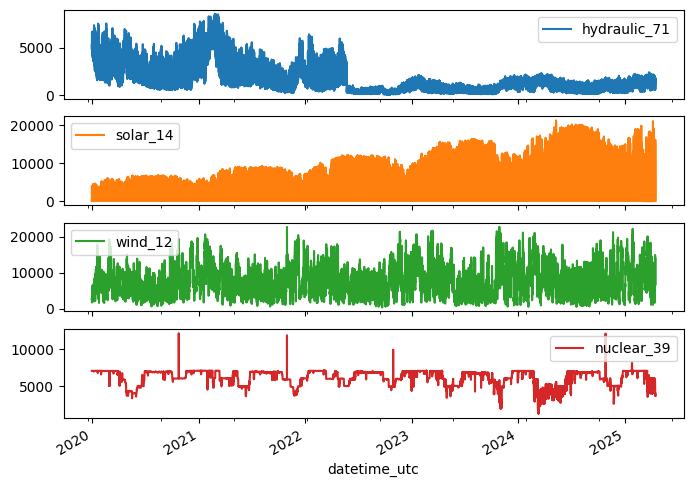

In [48]:
plot_cols = ['hydraulic_71', 'solar_14', 'wind_12', 'nuclear_39']
plot_features = df[plot_cols]
plot_features.index = date_time
plot_features.plot(subplots=True)


## Inspect and clean up
Lets inspect the data, clean it up, and look for some weird values

In [53]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
hydraulic_71,46361.0,1580.760770,1483.706974,39.050,497.5750,1099.800,2091.8000,8610.60
hydraulic_36,46362.0,2671.117782,1858.137726,204.700,1154.5250,2164.450,3764.2000,9528.00
hydraulic_1,46362.0,2790.630685,1900.980982,237.300,1233.6250,2303.850,3909.3500,9720.70
solar_14,46256.0,3520.616525,4811.277282,0.100,38.0000,417.200,6110.3000,21273.90
wind_12,46362.0,7563.038214,4015.861919,392.800,4373.7750,6824.500,10127.0750,22685.60
nuclear_39,46362.0,6231.196437,979.835260,1321.800,5778.5500,6796.200,7013.9000,12146.40
nuclear_4,46362.0,6188.131778,1101.558238,1246.700,5790.0000,6820.000,7028.2500,12146.40
nuclear_74,46361.0,3697.287749,2449.036333,797.025,1526.8250,1771.700,6117.4000,12146.40
peninsula_forecast_460,46362.0,26956.463440,4378.697120,8644.000,23405.0000,26930.000,30239.0000,41615.00
scheduled_demand_365,46361.0,13860.737092,9199.278111,3385.775,5711.7500,7133.400,22625.7000,35791.70


In [55]:
df.isna().sum()

hydraulic_71                           1
hydraulic_36                           0
hydraulic_1                            0
solar_14                             106
wind_12                                0
nuclear_39                             0
nuclear_4                              0
nuclear_74                             1
peninsula_forecast_460                 0
scheduled_demand_365                   1
scheduled_demand_358                   0
scheduled_demand_372                   0
daily_spot_market_600_España           0
daily_spot_market_600_Portugal         0
average_demand_price_573_Baleares     48
average_demand_price_573_Canarias     48
average_demand_price_573_Ceuta        48
average_demand_price_573_Melilla      48
dtype: int64

I'm gonna fill the data with the default method

In [56]:
df = df.ffill()
df.isna().sum()

hydraulic_71                         0
hydraulic_36                         0
hydraulic_1                          0
solar_14                             0
wind_12                              0
nuclear_39                           0
nuclear_4                            0
nuclear_74                           0
peninsula_forecast_460               0
scheduled_demand_365                 0
scheduled_demand_358                 0
scheduled_demand_372                 0
daily_spot_market_600_España         0
daily_spot_market_600_Portugal       0
average_demand_price_573_Baleares    0
average_demand_price_573_Canarias    0
average_demand_price_573_Ceuta       0
average_demand_price_573_Melilla     0
dtype: int64

In [57]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

### Split the data

In [58]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.6)]
val_df = df[int(n*0.6):int(n*0.8)]
test_df = df[int(n*0.8):]

num_features = df.shape[1]


### Normalize the data

In [59]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std


Some plots

/tmp/ipykernel_9476/3214313372.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


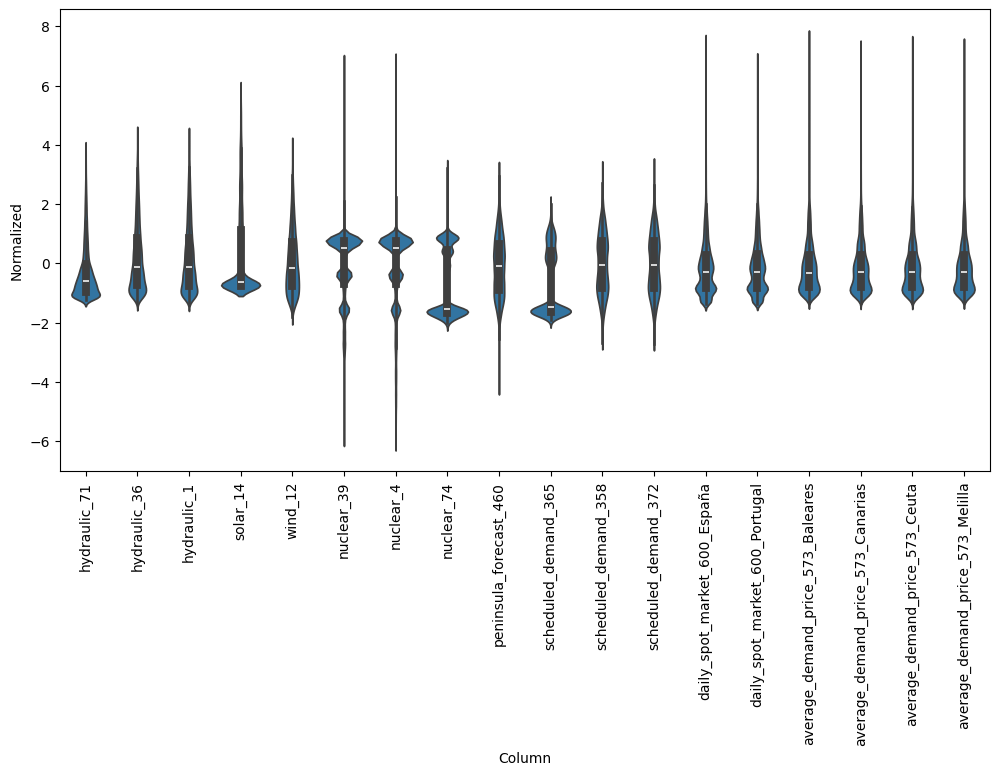

In [60]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

### Data windowing. 
First try im gonna predict one hour having 6 hours


In [61]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

      # Slicing doesn't preserve static shape information, so set the shapes
      # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def plot(self, model=None, plot_col='daily_spot_market_600_España', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                            label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                                        marker='X', edgecolors='k', label='Predictions',
                                        c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')


    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])


In [62]:
w = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['daily_spot_market_600_España'])

This is the way i create an example, but adding example property this is not needed.
Anyway this aint gonna work because example is a property and got no setter. 
Gotta comment the example class property for running this. 

In [63]:
# example_window = tf.stack([np.array(train_df[:w.total_window_size]),
#                            np.array(train_df[100:100+w.total_window_size]),
#                            np.array(train_df[200:200+w.total_window_size])])

# example_inputs, example_labels = w.split_window(example_window)

# w.example = example_inputs, example_labels

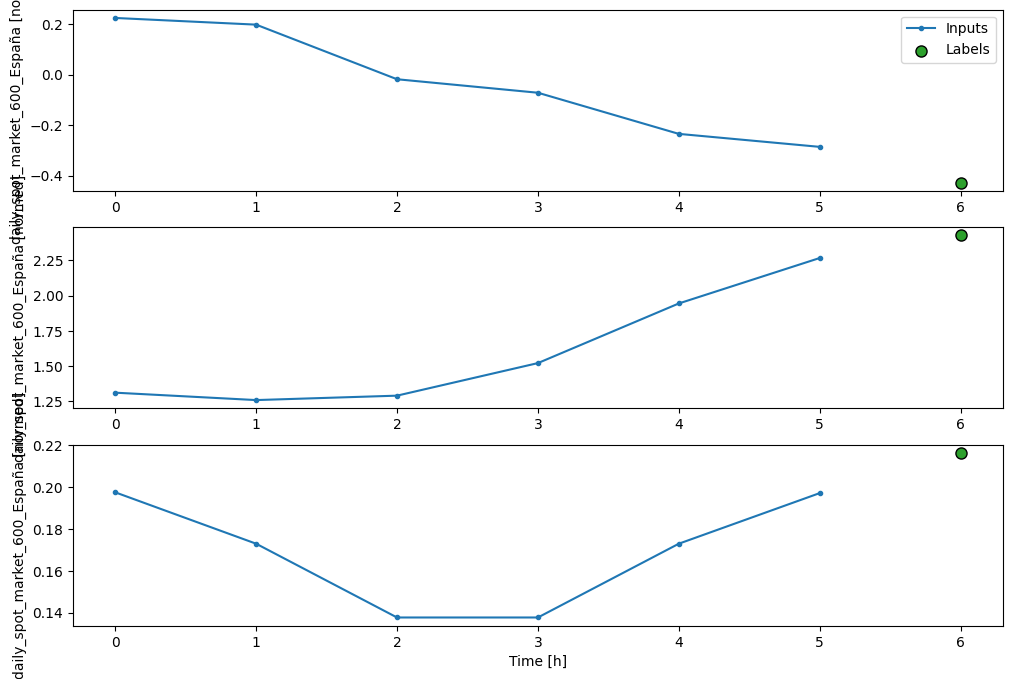

In [64]:
w.plot()

## Simplest model

The simplest model I can build is the single step model. Here we got it.

In [65]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['daily_spot_market_600_España'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['daily_spot_market_600_España']

In [66]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 18)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

In [67]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [68]:
baseline = Baseline(label_index=column_indices['daily_spot_market_600_España'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 0.0250 - mean_absolute_error: 0.1008


In [69]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['daily_spot_market_600_España'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['daily_spot_market_600_España']

In [70]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 18)
Output shape: (32, 24, 1)


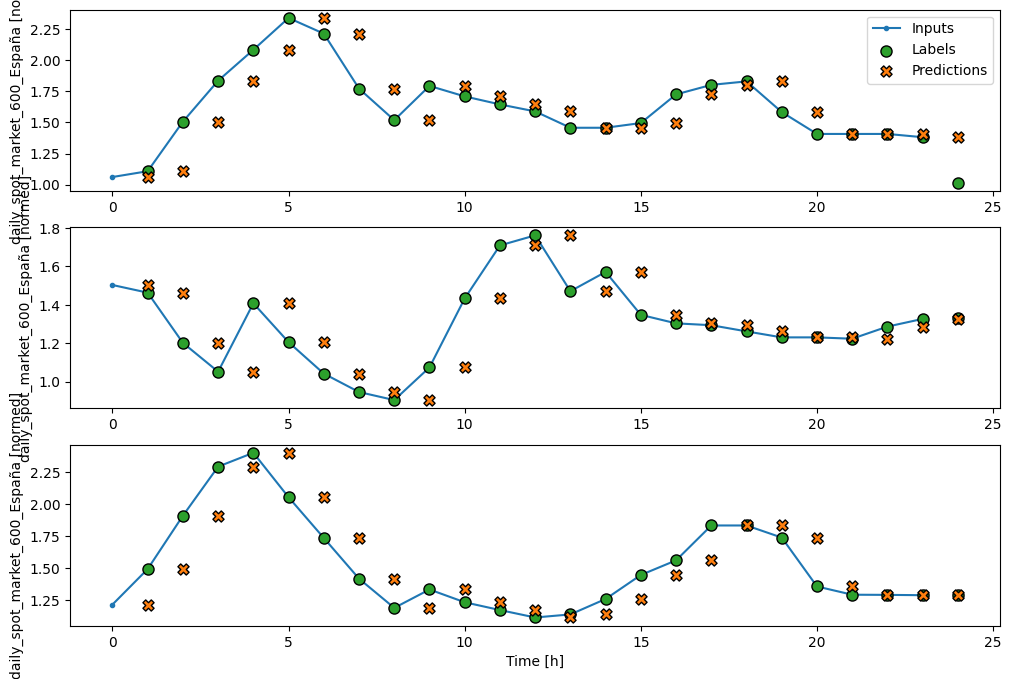

In [71]:
wide_window.plot(baseline)

## Linear model

An easy and simple model quite more interesting than the previous one.

In [73]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

As we are training a lot of models and I'm gonna save an auxiliar function here to be used everywhere needed.

In [74]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [75]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val, return_dict=True)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
870/870 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7070 - mean_absolute_error: 0.5522 - val_loss: 0.0923 - val_mean_absolute_error: 0.2221
Epoch 2/20
870/870 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0307 - mean_absolute_error: 0.1188 - val_loss: 0.0521 - val_mean_absolute_error: 0.1619
Epoch 3/20
870/870 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0251 - mean_absolute_error: 0.1025 - val_loss: 0.0411 - val_mean_absolute_error: 0.1400
Epoch 4/20
870/870 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0235 - mean_absolute_error: 0.0961 - val_loss: 0.0366 - val_mean_absolute_error: 0.1312
Epoch 5/20
870/870 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0228 - mean_absolute_error: 0.0930 - val_loss: 0.0343 - val_mean_absolute_error: 0.1276
Epoch 6/20
870/870 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0226 - mean_absolute_error: 0.0915 - val_loss: 0.0321 - val_mean_absolute_error: 0.1242
Epoch 7/20
870/870 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0225 - mean_absolute_error: 0.0910 - v

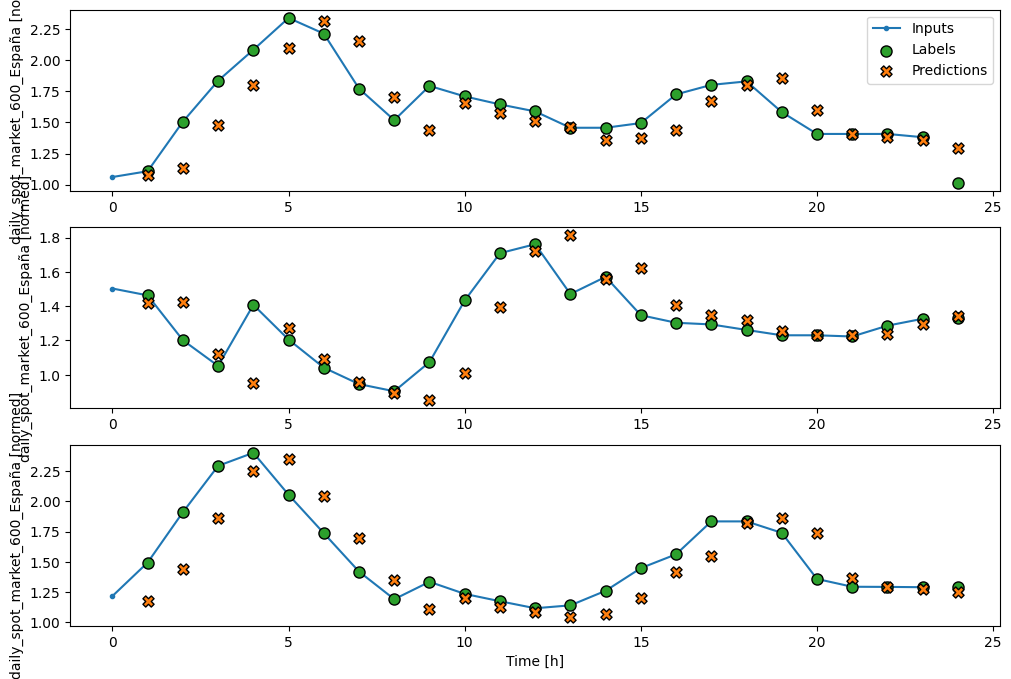

In [76]:
wide_window.plot(linear)

We can easily interpret the model due to its simplicity. It's really easy to see the weights on each input.

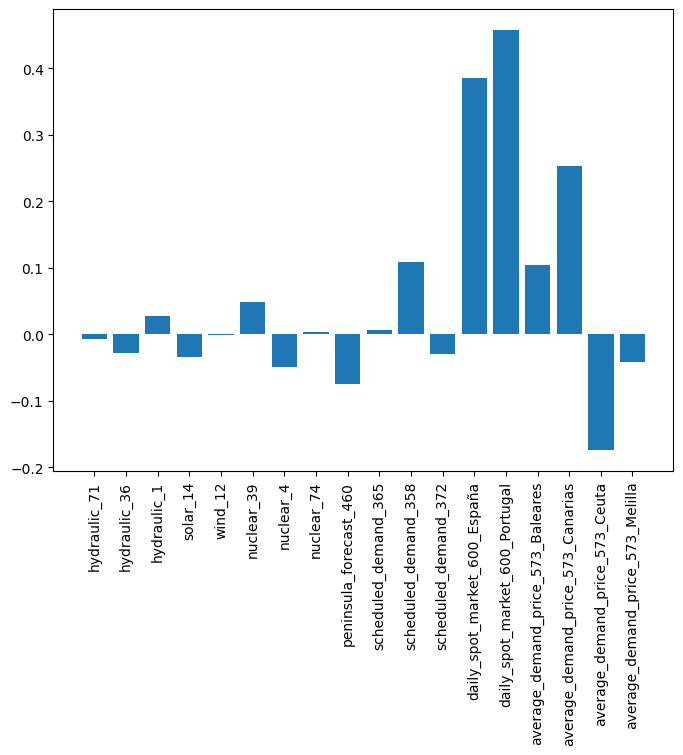

In [77]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)